# Восстановление золота из руды

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('/datasets/gold_recovery_train.csv')
test_df = pd.read_csv('/datasets/gold_recovery_test.csv')
full_df = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

In [5]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

In [6]:
train_df.isna().sum()

date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64

In [7]:
test_df.isna().sum()

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


In [8]:
full_df.isna().sum()

date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64

Датафрейм full содержит 87 столбцов и 22716 строк, есть пропуски. 
Датафрейм train содержит также 87 столбцов и 16859 строк, есть пропуски. Датафрейм test содержит 53 столбцов и 5856 строк,  есть пропуски.

In [9]:
for column in train_df.columns:
    print('Уникальные значения столбца', column)
    print(train_df[column].unique())
    print('Количество пропусков в каждом столбце')    
    print(train_df.isna().mean())

Уникальные значения столбца date
['2016-01-15 00:00:00' '2016-01-15 01:00:00' '2016-01-15 02:00:00' ...
 '2018-08-18 08:59:59' '2018-08-18 09:59:59' '2018-08-18 10:59:59']
Количество пропусков в каждом столбце
date                                          0.000000
final.output.concentrate_ag                   0.004270
final.output.concentrate_pb                   0.004270
final.output.concentrate_sol                  0.021945
final.output.concentrate_au                   0.004211
                                                ...   
secondary_cleaner.state.floatbank5_a_level    0.005042
secondary_cleaner.state.floatbank5_b_air      0.005042
secondary_cleaner.state.floatbank5_b_level    0.004982
secondary_cleaner.state.floatbank6_a_air      0.006109
secondary_cleaner.state.floatbank6_a_level    0.005042
Length: 87, dtype: float64
Уникальные значения столбца final.output.concentrate_ag
[6.05540276 6.02936857 6.05592607 ... 3.10999751 3.36724104 3.59837494]
Количество пропусков в каждом 

In [10]:
for column in full_df.columns:
    print('Уникальные значения столбца', column)
    print(full_df[column].unique())
    print('Количество пропусков в каждом столбце')    
    print(full_df.isna().mean())

Уникальные значения столбца date
['2016-01-15 00:00:00' '2016-01-15 01:00:00' '2016-01-15 02:00:00' ...
 '2018-08-18 08:59:59' '2018-08-18 09:59:59' '2018-08-18 10:59:59']
Количество пропусков в каждом столбце
date                                          0.000000
final.output.concentrate_ag                   0.003918
final.output.concentrate_pb                   0.003830
final.output.concentrate_sol                  0.016948
final.output.concentrate_au                   0.003786
                                                ...   
secondary_cleaner.state.floatbank5_a_level    0.004446
secondary_cleaner.state.floatbank5_b_air      0.004446
secondary_cleaner.state.floatbank5_b_level    0.004402
secondary_cleaner.state.floatbank6_a_air      0.005239
secondary_cleaner.state.floatbank6_a_level    0.004446
Length: 87, dtype: float64
Уникальные значения столбца final.output.concentrate_ag
[6.05540276 6.02936857 6.05592607 ... 3.10999751 3.36724104 3.59837494]
Количество пропусков в каждом 

Рассчитаем эффективность обогащения чернового концентрата rougher.output.recovery из обучающей выборки. Предварительно удалим пропуски из столбцов со значением NaN.

соседние параметры часто похожи, и так как главное что нет пропусков в целевых признаках, а другие технологические признаки восстанавливать опасно для результата, поэтому заполнил все данные стандартным ffill - этот метод даст заполнение предыдущими значениями , выглядит более логичным вариантом, так как данные  связаны логически технологическим процессом

In [14]:
train_df = train_df.fillna(method = 'ffill')
full_df = full_df.fillna(method = 'ffill')

In [25]:
full_df[full_df['final.output.concentrate_ag'].isna()]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level


In [26]:
train_df[train_df['rougher.output.concentrate_au'].isna()]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level


In [27]:
#train_df.dropna(subset = ['rougher.output.concentrate_au', 'rougher.input.feed_au',
#                                   'rougher.output.tail_au','rougher.output.recovery'], inplace=True)
#train_df.info()

In [16]:
train_df['rougher.output.concentrate_au'].isna().sum()

0

In [17]:
train_df['rougher.input.feed_au'].isna().sum()

0

In [18]:
train_df['rougher.output.tail_au'].isna().sum()

0

In [19]:
train_df['rougher.output.recovery'].isna().sum()

0

In [21]:
concentrate_au_column = train_df['rougher.output.concentrate_au']
feed_au_column = train_df['rougher.input.feed_au']
tail_au_column = train_df['rougher.output.tail_au']
input_recovery = train_df['rougher.output.recovery']
calculated_recovery = concentrate_au_column * (feed_au_column - tail_au_column) / feed_au_column / (concentrate_au_column - tail_au_column) * 100
print('Абсолютная средняя ошибка =', mean_absolute_error(input_recovery, calculated_recovery))

Абсолютная средняя ошибка = 1.0512313043960013e-14


MAE имеет очень малое отклонение - это значит, что расчетное значение rougher.output.recovery совпадает с данными из столбца.

почистим данные от пропущенных значений в обучающей и тестовой выборке.

In [22]:
cleaned_train_df = train_df.dropna()
cleaned_train_df.isna().mean()

date                                          0.0
final.output.concentrate_ag                   0.0
final.output.concentrate_pb                   0.0
final.output.concentrate_sol                  0.0
final.output.concentrate_au                   0.0
                                             ... 
secondary_cleaner.state.floatbank5_a_level    0.0
secondary_cleaner.state.floatbank5_b_air      0.0
secondary_cleaner.state.floatbank5_b_level    0.0
secondary_cleaner.state.floatbank6_a_air      0.0
secondary_cleaner.state.floatbank6_a_level    0.0
Length: 87, dtype: float64

In [23]:
cleaned_test_df = test_df.dropna()
cleaned_test_df.isna().mean()

date                                          0.0
primary_cleaner.input.sulfate                 0.0
primary_cleaner.input.depressant              0.0
primary_cleaner.input.feed_size               0.0
primary_cleaner.input.xanthate                0.0
primary_cleaner.state.floatbank8_a_air        0.0
primary_cleaner.state.floatbank8_a_level      0.0
primary_cleaner.state.floatbank8_b_air        0.0
primary_cleaner.state.floatbank8_b_level      0.0
primary_cleaner.state.floatbank8_c_air        0.0
primary_cleaner.state.floatbank8_c_level      0.0
primary_cleaner.state.floatbank8_d_air        0.0
primary_cleaner.state.floatbank8_d_level      0.0
rougher.input.feed_ag                         0.0
rougher.input.feed_pb                         0.0
rougher.input.feed_rate                       0.0
rougher.input.feed_size                       0.0
rougher.input.feed_sol                        0.0
rougher.input.feed_au                         0.0
rougher.input.floatbank10_sulfate             0.0


В тестовой выборке отсуствуют столбцы этапов rougher.output, rougher.calculation, final.output, primary_cleaner.output и secondary_cleaner.output. Эти данные будут получены по результатам технологического процесса. Это онлайн метрики. Остальные столбцы исторически известны - значит это офлайн метрики.

Выделим столбцы из тестовой выборки, по которым будет обучаться модель. Столбец data не несет смысла для обучающей модели. Для предсказания rougher.output.recovery будут использоватся данные из стобцов этапа rougher. Для вычисления final.output.recovery будут использованы все столбцы из тестовой выборки.

In [24]:
features_columns = cleaned_test_df.columns[1:]
rougher_features_columns = set(features_columns[12:34])
final_features_columns = set(features_columns)
print(rougher_features_columns)
print()
print(final_features_columns)

{'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_d_air', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.floatbank10_sulfate', 'rougher.input.feed_size', 'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_e_level', 'rougher.input.feed_sol', 'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_f_level', 'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_a_air', 'rougher.input.floatbank11_xanthate', 'rougher.input.floatbank10_xanthate', 'rougher.input.feed_rate', 'rougher.input.floatbank11_sulfate', 'rougher.state.floatbank10_c_air', 'rougher.input.feed_au'}

{'primary_cleaner.state.floatbank8_a_air', 'secondary_cleaner.state.floatbank2_a_air', 'rougher.state.floatbank10_e_air', 'primary_cleaner.state.floatbank8_b_level', 'primary_cleaner.state.floatbank8_c_air', 'secondary_cleaner.state.floatbank6_a_level', 'roughe

Пройдемся по ключевым столбцам в обучающей выборке.

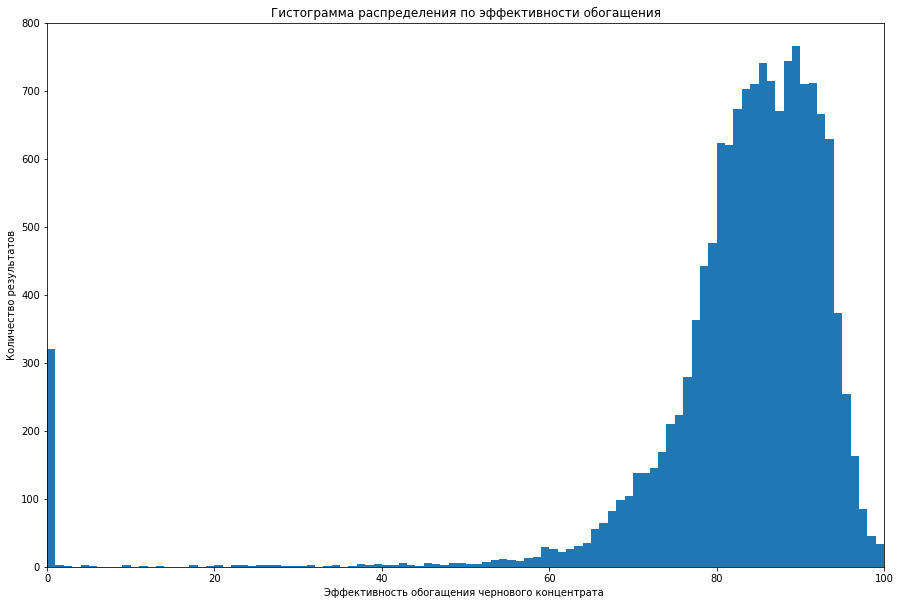

In [28]:
plt.figure(figsize = [15,10])

plt.hist(cleaned_train_df['rougher.output.recovery'], bins = 100)

plt.xlim([0, 100])
plt.ylim([0, 800])

plt.xlabel("Эффективность обогащения чернового концентрата ")
plt.ylabel("Количество результатов")

plt.title("Гистограмма распределения по эффективности обогащения")
plt.show()

Изучим нулевые значения в столбце rougher.output.recovery.

In [29]:
cleaned_train_df[cleaned_train_df['rougher.output.recovery'] < 1].head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
45,2016-01-16 21:00:00,4.566664,10.406178,4.588698,46.614456,68.403877,10.705777,1.509070,17.875134,2.509776,...,14.025588,-550.404242,12.028925,-550.570104,10.052072,-500.797905,7.984500,-499.581046,11.982025,-599.161228
46,2016-01-16 22:00:00,4.577832,10.691605,5.274175,46.250638,70.675633,10.728531,1.641216,18.349339,2.540843,...,14.094808,-550.676337,12.004728,-550.496522,9.953139,-500.330920,8.012074,-500.133530,11.975316,-598.839683
47,2016-01-16 23:00:00,4.591462,10.628846,5.688961,46.663335,55.088448,10.694584,1.671644,17.910312,2.686782,...,13.997488,-551.224653,11.971272,-550.095619,9.981163,-502.869109,7.941184,-500.623610,12.018837,-600.916665
48,2016-01-17 00:00:00,5.296830,10.597469,5.688961,44.015642,41.962008,11.975654,1.846558,8.138408,2.889469,...,14.006476,-549.388727,11.975967,-550.778624,9.989726,-499.607365,7.958252,-498.882560,11.967977,-599.440603
49,2016-01-17 01:00:00,7.256114,9.017677,5.688961,43.389252,41.962008,12.100582,1.758360,4.606019,3.202483,...,14.032364,-549.326033,11.987133,-549.583570,10.094584,-492.041563,8.054770,-498.802262,11.961330,-597.272218


In [30]:
cleaned_train_df[cleaned_train_df['rougher.output.concentrate_au'] < 1].head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
45,2016-01-16 21:00:00,4.566664,10.406178,4.588698,46.614456,68.403877,10.705777,1.509070,17.875134,2.509776,...,14.025588,-550.404242,12.028925,-550.570104,10.052072,-500.797905,7.984500,-499.581046,11.982025,-599.161228
46,2016-01-16 22:00:00,4.577832,10.691605,5.274175,46.250638,70.675633,10.728531,1.641216,18.349339,2.540843,...,14.094808,-550.676337,12.004728,-550.496522,9.953139,-500.330920,8.012074,-500.133530,11.975316,-598.839683
47,2016-01-16 23:00:00,4.591462,10.628846,5.688961,46.663335,55.088448,10.694584,1.671644,17.910312,2.686782,...,13.997488,-551.224653,11.971272,-550.095619,9.981163,-502.869109,7.941184,-500.623610,12.018837,-600.916665
48,2016-01-17 00:00:00,5.296830,10.597469,5.688961,44.015642,41.962008,11.975654,1.846558,8.138408,2.889469,...,14.006476,-549.388727,11.975967,-550.778624,9.989726,-499.607365,7.958252,-498.882560,11.967977,-599.440603
49,2016-01-17 01:00:00,7.256114,9.017677,5.688961,43.389252,41.962008,12.100582,1.758360,4.606019,3.202483,...,14.032364,-549.326033,11.987133,-549.583570,10.094584,-492.041563,8.054770,-498.802262,11.961330,-597.272218


В данных нет информации о этапе rougher. Удалим эти значения, так как они могут исказить данные.

In [31]:
cleaned_train_df = cleaned_train_df.drop(cleaned_train_df[cleaned_train_df['rougher.output.recovery'] == 0].index)

In [32]:
cleaned_train_df[cleaned_train_df['rougher.output.recovery'] < 1].head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level


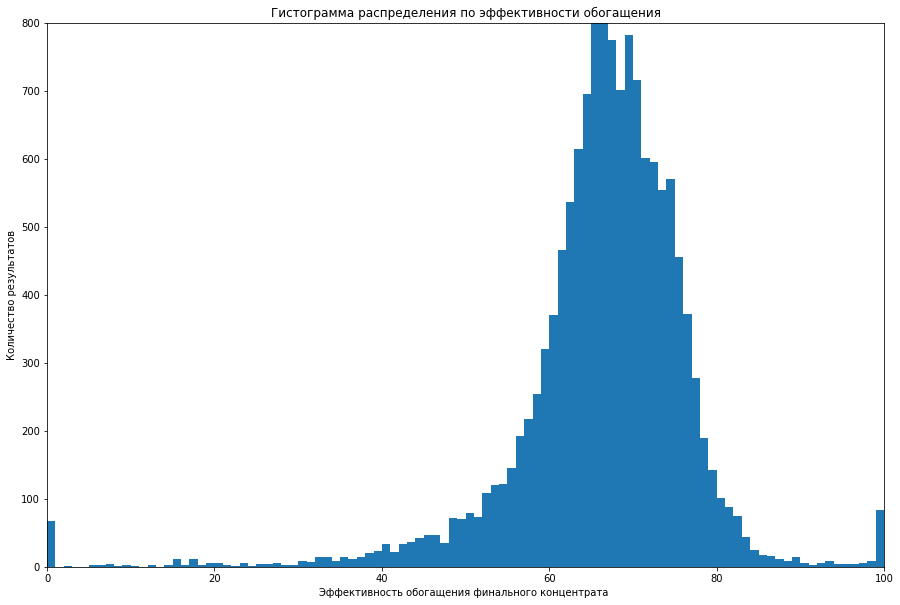

In [33]:
plt.figure(figsize = [15,10])

plt.hist(cleaned_train_df['final.output.recovery'], bins = 100)

plt.xlim([0, 100])
plt.ylim([0, 800])

plt.xlabel("Эффективность обогащения финального концентрата ")
plt.ylabel("Количество результатов")

plt.title("Гистограмма распределения по эффективности обогащения")
plt.show()

In [34]:
cleaned_train_df[cleaned_train_df['final.output.recovery'] < 1].head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
707,2016-02-13 11:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,8.894029,0.843584,15.417342,1.779052,...,21.991762,-399.587122,21.988937,-401.366408,22.995012,-399.370680,20.966863,-399.308354,24.987274,-399.619808
1139,2016-03-02 11:00:00,4.637727,12.557566,7.821058,41.529734,0.463711,11.388568,1.893716,7.735606,4.115341,...,13.974818,-578.520549,14.065672,-501.248199,12.011447,-500.417855,10.025794,-499.889108,20.033958,-499.999036
1354,2016-03-11 10:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,10.817313,1.462800,16.407607,2.984504,...,11.979352,-453.431061,12.003445,-450.179844,11.982937,-449.856468,9.927727,-450.521700,19.971682,-500.685521
1355,2016-03-11 11:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,10.436792,1.207636,17.800392,2.747294,...,12.034636,-446.590944,12.130405,-449.684812,11.844983,-450.881424,9.916784,-449.542871,20.004767,-500.137068
1356,2016-03-11 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,10.637073,1.405778,17.195897,2.791440,...,12.016716,-496.613149,12.055535,-496.908551,12.091144,-496.404140,9.976074,-496.783155,19.921634,-500.769011


In [35]:
cleaned_train_df = cleaned_train_df.drop(cleaned_train_df[cleaned_train_df['final.output.recovery'] == 0].index)

In [36]:
cleaned_train_df[cleaned_train_df['final.output.recovery'] < 1].head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
1139,2016-03-02 11:00:00,4.637727,12.557566,7.821058,41.529734,0.463711,11.388568,1.893716,7.735606,4.115341,...,13.974818,-578.520549,14.065672,-501.248199,12.011447,-500.417855,10.025794,-499.889108,20.033958,-499.999036
14274,2018-05-02 17:59:59,5.644008,6.994057,7.987903,50.518813,0.430264,8.709877,0.452147,8.533550,0.886103,...,30.030464,-497.628390,20.070540,-499.776095,24.978862,-499.085376,23.029016,-500.164084,25.006625,-499.199960
14573,2018-05-15 04:59:59,0.010000,0.010000,0.010000,0.010000,0.168611,8.069722,1.734258,5.262840,2.452356,...,30.028409,-507.406186,22.008754,-501.816732,24.992438,-503.865882,23.019383,-500.472409,25.002424,-503.326766
14631,2018-05-17 14:59:59,0.010000,0.010000,0.010000,0.010000,0.168611,10.973703,1.956650,5.262840,5.205719,...,30.016229,-398.270850,22.002711,-499.522602,24.980643,-499.283705,22.984288,-500.059916,25.013956,-500.408074
14632,2018-05-17 15:59:59,0.010000,0.010000,0.010000,0.010000,0.168611,9.987548,1.440766,4.277092,4.050977,...,29.954721,-398.425395,21.946049,-500.062361,24.992471,-500.467714,22.978081,-499.791793,24.992488,-500.157939


In [37]:
cleaned_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13905 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  13905 non-null object
final.output.concentrate_ag                           13905 non-null float64
final.output.concentrate_pb                           13905 non-null float64
final.output.concentrate_sol                          13905 non-null float64
final.output.concentrate_au                           13905 non-null float64
final.output.recovery                                 13905 non-null float64
final.output.tail_ag                                  13905 non-null float64
final.output.tail_pb                                  13905 non-null float64
final.output.tail_sol                                 13905 non-null float64
final.output.tail_au                                  13905 non-null float64
primary_cleaner.input.sulfate                         13905 non-null float64
primary_cleaner.input.depressant             

исследуем колонки primary_cleaner.output и secondary_cleaner.output на предмет нулевых значений.

In [38]:
cleaned_train_df[cleaned_train_df['secondary_cleaner.output.tail_au'] < 1]['secondary_cleaner.output.tail_au'].count()

771

In [39]:
cleaned_train_df[cleaned_train_df['primary_cleaner.output.concentrate_au'] < 1]['primary_cleaner.output.concentrate_au'].count()

222

### Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [40]:
test_col = test_df.columns

In [41]:
full_col = full_df.columns

In [42]:
diff_list = list(set(full_col) - set(test_col))

In [43]:
diff_list = pd.Series(diff_list)
diff_list.sort_values()

18                          final.output.concentrate_ag
22                          final.output.concentrate_au
16                          final.output.concentrate_pb
15                         final.output.concentrate_sol
17                                final.output.recovery
7                                  final.output.tail_ag
6                                  final.output.tail_au
1                                  final.output.tail_pb
10                                final.output.tail_sol
23                primary_cleaner.output.concentrate_ag
25                primary_cleaner.output.concentrate_au
26                primary_cleaner.output.concentrate_pb
14               primary_cleaner.output.concentrate_sol
12                       primary_cleaner.output.tail_ag
8                        primary_cleaner.output.tail_au
21                       primary_cleaner.output.tail_pb
19                      primary_cleaner.output.tail_sol
0                       rougher.calculation.au_p

Каждый из этих признаков можно сделать целевым и предсказывать, так как это выходные признаки после каждого технологического этапа. В списке есть и наши целевые признаки final.output.recovery и rougher.output.recovery. В дальнейшем они понадобятся на этапе подсчета метрики sMAPE.

### Вывод по шагу 1

В данных присутвовали пропущенные значение и нулевые значения.
Неподходящие данные были удалены. Данные готовы к дальнейшему анализу.

## Анализ данных

Рассмотрим концентрацию веществ на каждом этапе.

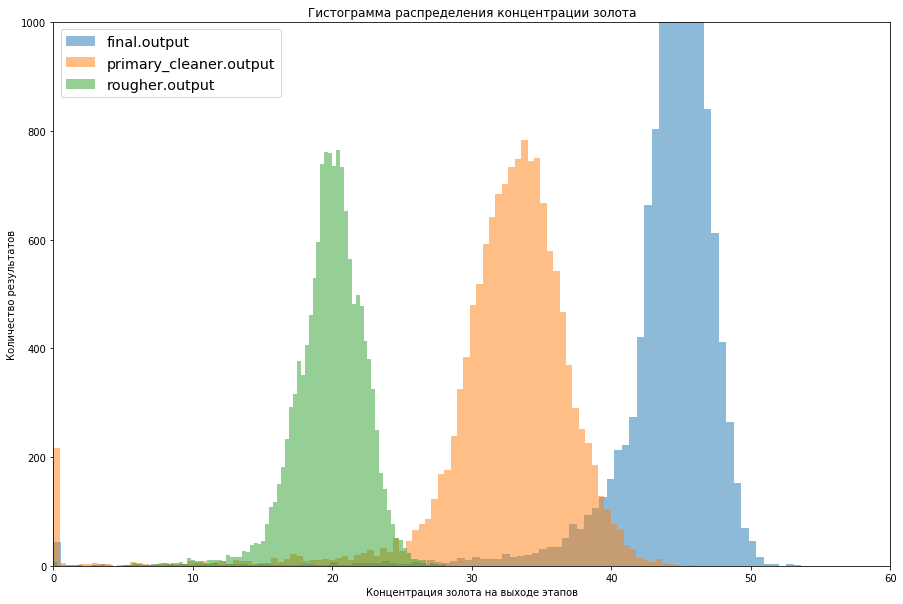

In [44]:
plt.figure(figsize = [15,10])

plt.hist(cleaned_train_df['final.output.concentrate_au'], bins = 100, label = 'final.output', alpha = .5)
plt.hist(cleaned_train_df['primary_cleaner.output.concentrate_au'], bins = 100, label = 'primary_cleaner.output', alpha = .5)
plt.hist(cleaned_train_df['rougher.output.concentrate_au'], bins = 100, label = 'rougher.output', alpha = .5)

plt.xlim([0, 60])
plt.ylim([0, 1000])

plt.xlabel("Концентрация золота на выходе этапов")
plt.ylabel("Количество результатов")

plt.legend(loc = 'upper left', fontsize = 'x-large')

plt.title("Гистограмма распределения концентрации золота")
plt.show()

Концентрация золота повышается с каждым этапом. Цель флотации и очисток увеличить концентрацию золота.

Рассмотрим тоже самое по серебру

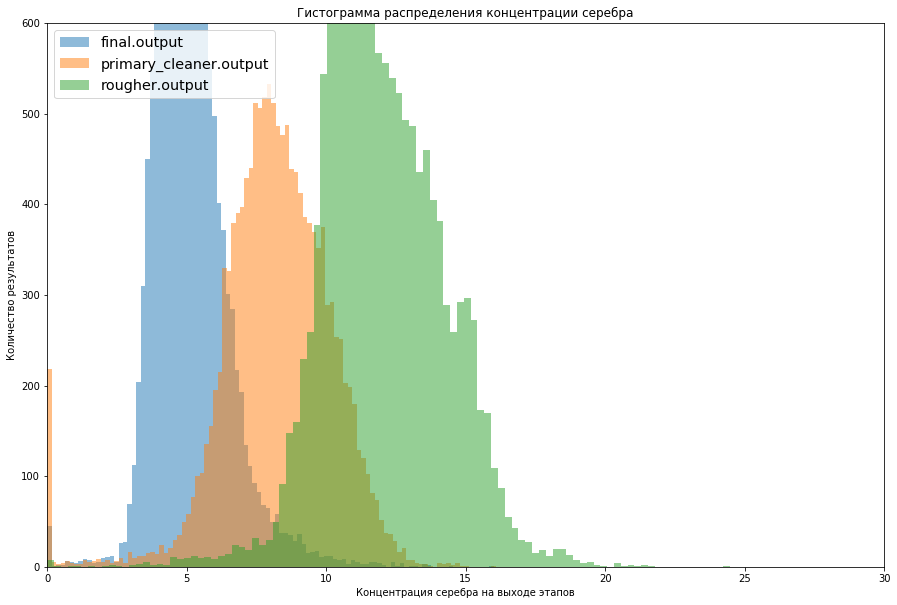

In [45]:
plt.figure(figsize = [15,10])

plt.hist(cleaned_train_df['final.output.concentrate_ag'], bins = 100, label = 'final.output', alpha = .5)
plt.hist(cleaned_train_df['primary_cleaner.output.concentrate_ag'], bins = 100, label = 'primary_cleaner.output', alpha = .5)
plt.hist(cleaned_train_df['rougher.output.concentrate_ag'], bins = 100, label = 'rougher.output', alpha = .5)

plt.xlim([0, 30])
plt.ylim([0, 600])

plt.xlabel("Концентрация серебра на выходе этапов")
plt.ylabel("Количество результатов")

plt.legend(loc = 'upper left', fontsize = 'x-large')

plt.title("Гистограмма распределения концентрации серебра")
plt.show()

Конецентрация серебра с каждым последующим шагом очистки понижается. Так как основным  металлом является золото, остальные металлы и соединения должны быть отфильтрованы.

Рассмотрим тоже самое по свинцу

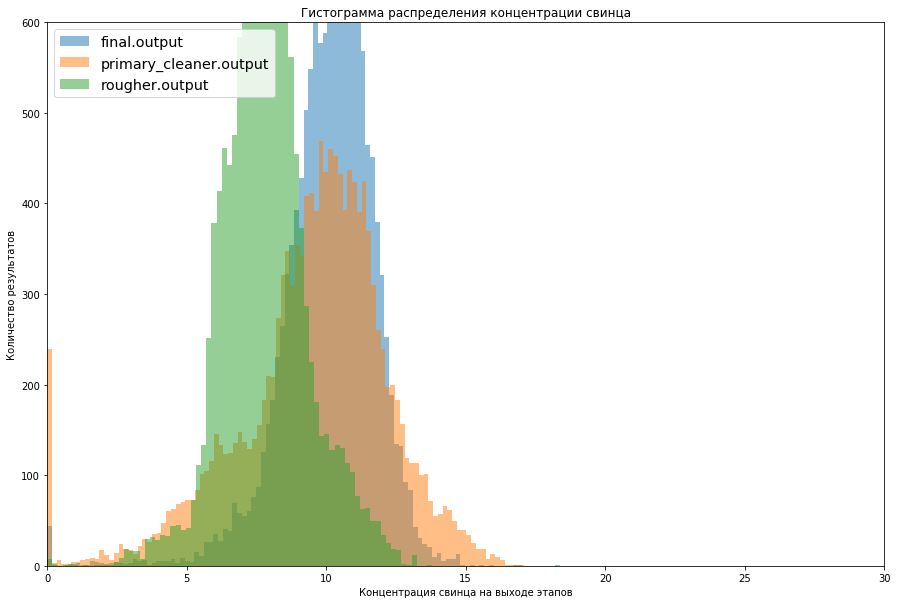

In [46]:
plt.figure(figsize = [15,10])

plt.hist(cleaned_train_df['final.output.concentrate_pb'], bins = 100, label = 'final.output', alpha = .5)
plt.hist(cleaned_train_df['primary_cleaner.output.concentrate_pb'], bins = 100, label = 'primary_cleaner.output', alpha = .5)
plt.hist(cleaned_train_df['rougher.output.concentrate_pb'], bins = 100, label = 'rougher.output', alpha = .5)

plt.xlim([0, 30])
plt.ylim([0, 600])

plt.xlabel("Концентрация свинца на выходе этапов")
plt.ylabel("Количество результатов")

plt.legend(loc = 'upper left', fontsize = 'x-large')

plt.title("Гистограмма распределения концентрации свинца")
plt.show()

Концентрация свинца с этапа rougher до primary_cleaner повышается, далее идет выравнивание, что объясняется химическими процесами очищения золота - при использовании азотнокислого выщелачивания в концентрате образуется много сульфата свинца. Повышение концентрации свинца в целом происходит не только из-за этого процесса, но и по причине очищения других составляющих из золотоносной руды.

Изучим размеры сырья на этапах обработки.

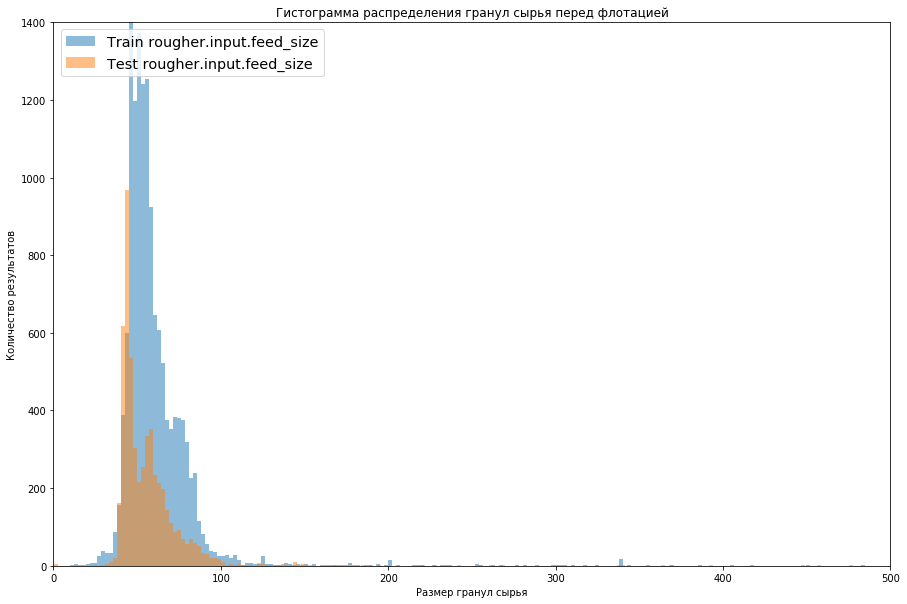

In [47]:
plt.figure(figsize = [15,10])

plt.hist(cleaned_train_df['rougher.input.feed_size'], bins = 200, label = 'Train rougher.input.feed_size', alpha = .5)
plt.hist(cleaned_test_df['rougher.input.feed_size'], bins = 200, label = 'Test rougher.input.feed_size', alpha = .5)

plt.xlim([0, 500])
plt.ylim([0, 1400])

plt.xlabel("Размер гранул сырья")
plt.ylabel("Количество результатов")

plt.legend(loc = 'upper left', fontsize = 'x-large')

plt.title("Гистограмма распределения гранул сырья перед флотацией")
plt.show()

Исходя из гистограммы распределение гранул до флотации похоже на нормальное со смещением влево как в обучающей, так и в тестовой выбрке. Существует много выбросов после размера гранул 100.

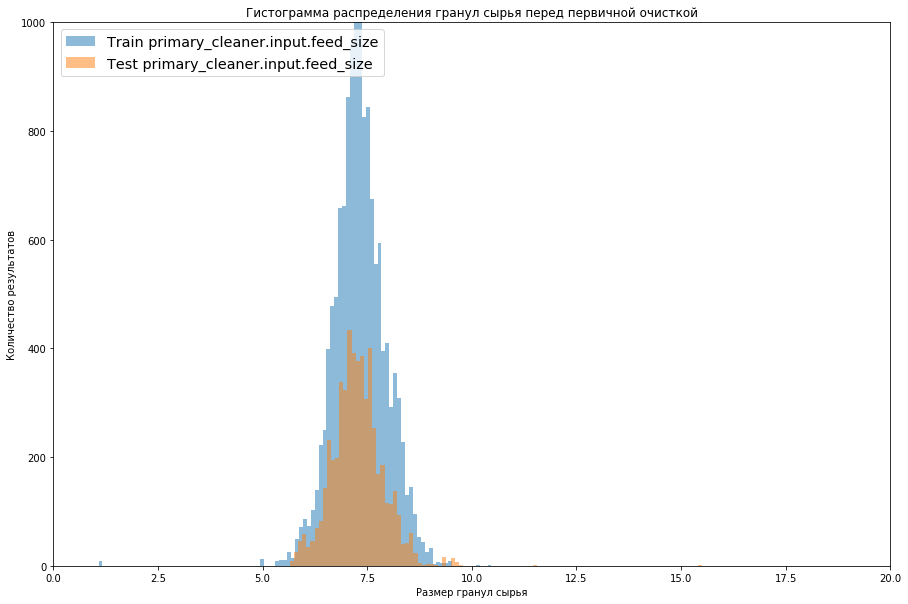

In [48]:
plt.figure(figsize = [15,10])

plt.hist(cleaned_train_df['primary_cleaner.input.feed_size'], bins = 100, label = 'Train primary_cleaner.input.feed_size', alpha = .5)
plt.hist(cleaned_test_df['primary_cleaner.input.feed_size'], bins = 100, label = 'Test primary_cleaner.input.feed_size', alpha = .5)

plt.xlim([0, 20])
plt.ylim([0, 1000])

plt.xlabel("Размер гранул сырья")
plt.ylabel("Количество результатов")

plt.legend(loc = 'upper left', fontsize = 'x-large')

plt.title("Гистограмма распределения гранул сырья перед первичной очисткой")
plt.show()

Размеры гранул перед первичной очисткой распределены по нормальному закону.

Подготовим столбцы с финальными концентрациями в обучающей выборке.

In [49]:
final_output_sum_train = (cleaned_train_df['final.output.concentrate_au'] + 
                                      cleaned_train_df['final.output.concentrate_ag'] + 
                                      cleaned_train_df['final.output.concentrate_pb'] +
                                      cleaned_train_df['final.output.concentrate_sol'])
primary_cleaner_output_sum_train = (cleaned_train_df['primary_cleaner.output.concentrate_au'] + 
                                                cleaned_train_df['primary_cleaner.output.concentrate_ag'] + 
                                                cleaned_train_df['primary_cleaner.output.concentrate_pb'] +
                                                cleaned_train_df['primary_cleaner.output.concentrate_sol'])
rougher_output_sum_train = (cleaned_train_df['rougher.output.concentrate_au'] + 
                                        cleaned_train_df['rougher.output.concentrate_ag'] + 
                                        cleaned_train_df['rougher.output.concentrate_pb'] +
                                        cleaned_train_df['rougher.output.concentrate_sol'])

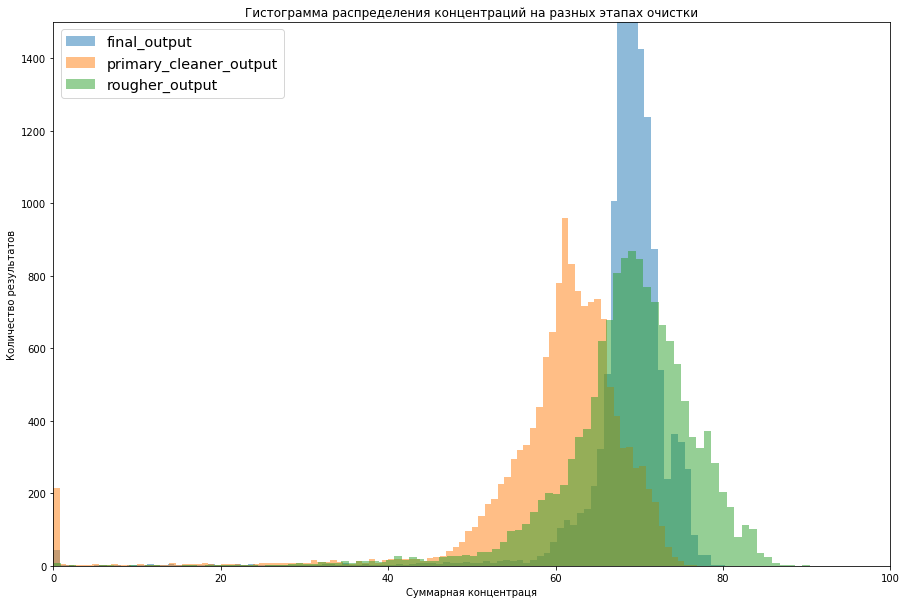

In [50]:
plt.figure(figsize = [15,10])

plt.hist(final_output_sum_train, bins = 100, label = 'final_output', alpha = .5)
plt.hist(primary_cleaner_output_sum_train, bins = 100, label = 'primary_cleaner_output', alpha = .5)
plt.hist(rougher_output_sum_train, bins = 100, label = 'rougher_output', alpha = .5)

plt.xlim([0, 100])
plt.ylim([0, 1500])

plt.xlabel("Суммарная концентраця")
plt.ylabel("Количество результатов")

plt.legend(loc = 'upper left', fontsize = 'x-large')

plt.title("Гистограмма распределения концентраций на разных этапах очистки")
plt.show()

Рассмотрим график более подробно вблизи значений 0. 

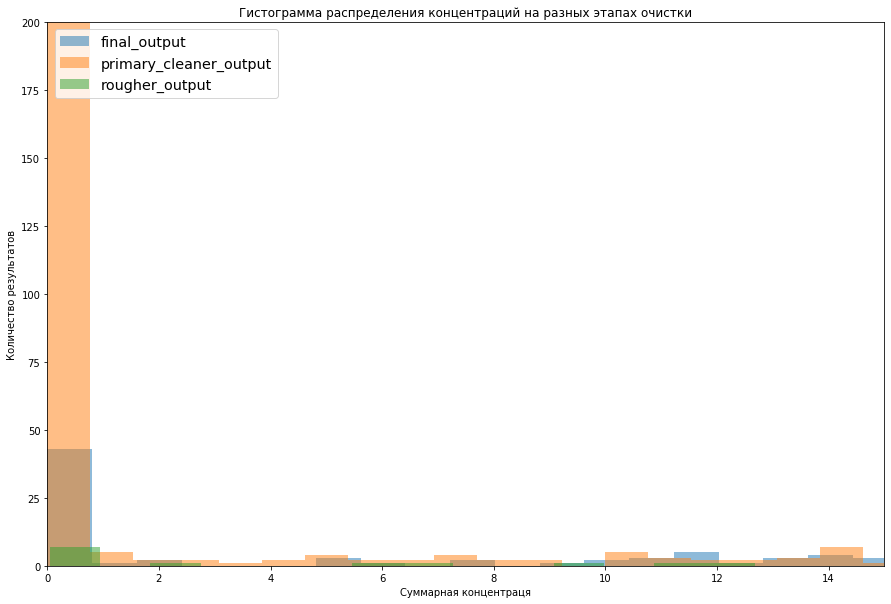

In [51]:
plt.figure(figsize = [15,10])

plt.hist(final_output_sum_train, bins = 100, label = 'final_output', alpha = .5)
plt.hist(primary_cleaner_output_sum_train, bins = 100, label = 'primary_cleaner_output', alpha = .5)
plt.hist(rougher_output_sum_train, bins = 100, label = 'rougher_output', alpha = .5)

plt.xlim([0, 15])
plt.ylim([0, 200])

plt.xlabel("Суммарная концентраця")
plt.ylabel("Количество результатов")

plt.legend(loc = 'upper left', fontsize = 'x-large')

plt.title("Гистограмма распределения концентраций на разных этапах очистки")
plt.show()

В силу того, что на этапе предобработки данных были выявлены строки с нулевыми значениями в колонке primary_cleaner.output эти же строки показывают и суммарную концентрацию, равную нулю, собственно они и являются аномалией, поэтому удалим их.

In [52]:
cleaned_train_df = cleaned_train_df.drop(cleaned_train_df[cleaned_train_df['primary_cleaner.output.concentrate_au'] == 0].index)
cleaned_train_df[cleaned_train_df['primary_cleaner.output.concentrate_au'] == 0].head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level


### Вывод по шагу 2

В результате анализа были изучены концетрации основных веществ на разных этапах очистки, размер гранул тестовой и обучающей выборки,
а также суммарная концентрация веществ. Аномалии удалены и данные готовы к обучению.

## Модель

Создадим разделение признаков для предсказания rougher.output.recovery и final.output.recovery.

In [53]:
# Подготовка признаков для final.output.recovery
columns_to_delete = set(cleaned_train_df.columns) - final_features_columns
print(columns_to_delete)
train_features_final = cleaned_train_df.drop(columns_to_delete, axis = 1)
print()
print(train_features_final.columns)
print(set(train_features_final.columns) - set(cleaned_test_df.columns))

{'rougher.calculation.au_pb_ratio', 'final.output.tail_pb', 'secondary_cleaner.output.tail_pb', 'rougher.output.tail_ag', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.output.concentrate_au', 'final.output.tail_au', 'final.output.tail_ag', 'primary_cleaner.output.tail_au', 'rougher.output.concentrate_pb', 'final.output.tail_sol', 'rougher.output.concentrate_ag', 'primary_cleaner.output.tail_ag', 'rougher.output.tail_pb', 'date', 'primary_cleaner.output.concentrate_sol', 'final.output.concentrate_sol', 'final.output.concentrate_pb', 'final.output.recovery', 'final.output.concentrate_ag', 'primary_cleaner.output.tail_sol', 'rougher.output.tail_au', 'primary_cleaner.output.tail_pb', 'final.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'secondary_cleaner.output.tail_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_pb', 'rougher.output.recovery', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.output.concen

In [54]:
# Подготовка признаков для rougher.output.recovery
columns_to_delete = set(train_features_final.columns) - rougher_features_columns
print(columns_to_delete)
train_features_rougher = train_features_final.drop(columns_to_delete, axis = 1)
print()
print(train_features_rougher.columns)

{'primary_cleaner.state.floatbank8_a_air', 'secondary_cleaner.state.floatbank2_a_air', 'primary_cleaner.state.floatbank8_b_level', 'primary_cleaner.state.floatbank8_c_air', 'secondary_cleaner.state.floatbank2_b_air', 'primary_cleaner.state.floatbank8_a_level', 'secondary_cleaner.state.floatbank4_b_air', 'primary_cleaner.state.floatbank8_d_air', 'primary_cleaner.state.floatbank8_d_level', 'primary_cleaner.state.floatbank8_c_level', 'secondary_cleaner.state.floatbank2_a_level', 'secondary_cleaner.state.floatbank5_a_level', 'primary_cleaner.input.sulfate', 'secondary_cleaner.state.floatbank4_a_air', 'secondary_cleaner.state.floatbank3_a_air', 'secondary_cleaner.state.floatbank4_b_level', 'secondary_cleaner.state.floatbank6_a_level', 'secondary_cleaner.state.floatbank5_b_air', 'secondary_cleaner.state.floatbank2_b_level', 'primary_cleaner.input.depressant', 'secondary_cleaner.state.floatbank3_b_level', 'secondary_cleaner.state.floatbank4_a_level', 'primary_cleaner.input.xanthate', 'seconda

Готовим целевой признак

In [55]:
train_target_final = cleaned_train_df['final.output.recovery']
train_target_rougher = cleaned_train_df['rougher.output.recovery']

Готовим признаки тестовой выборки

In [56]:
test_features = cleaned_test_df.drop('date', axis = 1)
test_features.columns

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatba

In [57]:
test_features_final = test_features
columns_to_delete = set(test_features_final.columns) - rougher_features_columns
print(columns_to_delete)
test_features_rougher = test_features_final.drop(columns_to_delete, axis = 1)

{'primary_cleaner.state.floatbank8_a_air', 'secondary_cleaner.state.floatbank2_a_air', 'primary_cleaner.state.floatbank8_b_level', 'primary_cleaner.state.floatbank8_c_air', 'secondary_cleaner.state.floatbank2_b_air', 'primary_cleaner.state.floatbank8_a_level', 'secondary_cleaner.state.floatbank4_b_air', 'primary_cleaner.state.floatbank8_d_air', 'primary_cleaner.state.floatbank8_d_level', 'primary_cleaner.state.floatbank8_c_level', 'secondary_cleaner.state.floatbank2_a_level', 'secondary_cleaner.state.floatbank5_a_level', 'primary_cleaner.input.sulfate', 'secondary_cleaner.state.floatbank4_a_air', 'secondary_cleaner.state.floatbank3_a_air', 'secondary_cleaner.state.floatbank4_b_level', 'secondary_cleaner.state.floatbank6_a_level', 'secondary_cleaner.state.floatbank5_b_air', 'secondary_cleaner.state.floatbank2_b_level', 'primary_cleaner.input.depressant', 'secondary_cleaner.state.floatbank3_b_level', 'secondary_cleaner.state.floatbank4_a_level', 'primary_cleaner.input.xanthate', 'seconda

Напишем функцию метрики качества для вычисления симметричного среднего абсолютного процентного отклонения (SMAPE).

In [58]:
def smape_ (rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted):
    n = rougher_recovery_real.shape[0]
    rougher_smape = ((2*abs(rougher_recovery_real - rougher_recovery_predicted)/
                     (abs(rougher_recovery_real) + abs(rougher_recovery_predicted))).sum() * 100 / n)
    final_smape = ((2*abs(final_recovery_real - final_recovery_predicted)/
                     (abs(final_recovery_real) + abs(final_recovery_predicted))).sum() * 100 / n)
    return rougher_smape * 0.25 + final_smape * 0.75

Выполним поиск лучшей модели для предсказаний из линейная регрессии, полиноминальной регрессии, регрессии Ridge и DecisionTreeRegressor

In [59]:
regressor = LinearRegression()
print('Mean R2 LinearRegression =', cross_val_score(regressor, train_features_final, train_target_final, cv = 5).mean())
print('Mean MAE LinearRegression =', cross_val_score(regressor, train_features_final, train_target_final, cv = 5, scoring = 'neg_mean_absolute_error').mean())

Mean R2 LinearRegression = -0.14222108433206823
Mean MAE LinearRegression = -7.177685166499368


Проверим влияние масштаба признаков на качество модели.

In [60]:
regressor = LinearRegression()
scaler = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaler),("linear_regression", regressor)])
print('Mean R2 LinearRegression =', cross_val_score(pipeline, train_features_final, train_target_final, cv = 5).mean())
print('Mean MAE LinearRegression =', cross_val_score(pipeline, train_features_final, train_target_final, cv = 5, scoring = 'neg_mean_absolute_error').mean())

Mean R2 LinearRegression = -0.1422210843320761
Mean MAE LinearRegression = -7.177685166499394


Влияние на масштаб признаков не выявлено

Перейдем к полиномиальной регрессии

In [61]:
regressor = LinearRegression()
polynomial_features = PolynomialFeatures(degree = 2, include_bias = False)
pipeline = Pipeline([("polynomial_features", polynomial_features),("linear_regression", regressor)])
print('Mean R2 PolynomialRegression =', cross_val_score(pipeline, train_features_final, train_target_final, cv = 5).mean())
print('Mean MAE PolynomialRegression =', cross_val_score(pipeline, train_features_final, train_target_final, cv = 5, scoring = 'neg_mean_absolute_error').mean())

Mean R2 PolynomialRegression = -23.685479616626367
Mean MAE PolynomialRegression = -27.26022042346755


Для Ridge и DecisionTreeRegressor применим метод GridSearchCV, так как в нем уже присутствует кросс-валидация.

In [62]:
regressor = Ridge()
hyperparams = [{'alpha':[0.1, 1, 10, 100], 'solver':['auto']},
                 {'alpha':[0.1, 1, 10, 100], 'solver':['svd']}, 
                 {'alpha':[0.1, 1, 10, 100], 'solver':['cholesky']},
                 {'alpha':[0.1, 1, 10, 100], 'solver':['lsqr']}, 
                 {'alpha':[0.1, 1, 10, 100], 'solver':['sparse_cg']}]

scores = ['r2', 'neg_mean_absolute_error']

for score in scores:
    print('# Tuning hyper-parameters for %s' % score)
    print()
    clf = GridSearchCV(regressor, hyperparams, scoring = score)
    clf.fit(train_features_final, train_target_final)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
    print()

# Tuning hyper-parameters for r2

Best parameters set found on development set:

{'alpha': 0.1, 'solver': 'lsqr'}

Grid scores on development set:

-0.468 (+/-0.490) for {'alpha': 0.1, 'solver': 'auto'}
-0.467 (+/-0.491) for {'alpha': 1, 'solver': 'auto'}
-0.458 (+/-0.497) for {'alpha': 10, 'solver': 'auto'}
-0.396 (+/-0.546) for {'alpha': 100, 'solver': 'auto'}
-0.468 (+/-0.490) for {'alpha': 0.1, 'solver': 'svd'}
-0.467 (+/-0.491) for {'alpha': 1, 'solver': 'svd'}
-0.458 (+/-0.497) for {'alpha': 10, 'solver': 'svd'}
-0.396 (+/-0.546) for {'alpha': 100, 'solver': 'svd'}
-0.468 (+/-0.490) for {'alpha': 0.1, 'solver': 'cholesky'}
-0.467 (+/-0.491) for {'alpha': 1, 'solver': 'cholesky'}
-0.458 (+/-0.497) for {'alpha': 10, 'solver': 'cholesky'}
-0.396 (+/-0.546) for {'alpha': 100, 'solver': 'cholesky'}
-0.301 (+/-0.598) for {'alpha': 0.1, 'solver': 'lsqr'}
-0.301 (+/-0.598) for {'alpha': 1, 'solver': 'lsqr'}
-0.301 (+/-0.598) for {'alpha': 10, 'solver': 'lsqr'}
-0.301 (+/-0.598) for {'alp

In [63]:
regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 21, 2)]
hyperparams = [{'criterion':['mse'], 'max_depth':max_depth_list, 'random_state':[15062020]},
               {'criterion':['mae'], 'max_depth':max_depth_list, 'random_state':[15062020]}]

print('# Tuning hyper-parameters')
print()
clf = GridSearchCV(regressor, hyperparams)
clf.fit(train_features_final, train_target_final)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
print()

# Tuning hyper-parameters

Best parameters set found on development set:

{'criterion': 'mae', 'max_depth': 4, 'random_state': 15062020}

Grid scores on development set:

-0.068 (+/-0.413) for {'criterion': 'mse', 'max_depth': 2, 'random_state': 15062020}
-0.405 (+/-0.785) for {'criterion': 'mse', 'max_depth': 4, 'random_state': 15062020}
-0.206 (+/-0.443) for {'criterion': 'mse', 'max_depth': 6, 'random_state': 15062020}
-0.621 (+/-0.444) for {'criterion': 'mse', 'max_depth': 8, 'random_state': 15062020}
-0.746 (+/-0.227) for {'criterion': 'mse', 'max_depth': 10, 'random_state': 15062020}
-0.835 (+/-0.235) for {'criterion': 'mse', 'max_depth': 12, 'random_state': 15062020}
-1.211 (+/-0.410) for {'criterion': 'mse', 'max_depth': 14, 'random_state': 15062020}
-1.332 (+/-0.135) for {'criterion': 'mse', 'max_depth': 16, 'random_state': 15062020}
-1.253 (+/-0.561) for {'criterion': 'mse', 'max_depth': 18, 'random_state': 15062020}
-1.175 (+/-0.365) for {'criterion': 'mse', 'max_depth': 20,

Проверим лучшие модели по метрикам на созданной метрике smape. Проверим реальные данные.

In [64]:
rougher_recovery_real = full_df.loc[test_features_rougher.index,'rougher.output.recovery']
final_recovery_real = full_df.loc[test_features_final.index,'final.output.recovery']
print('Процент пропусков в общей выборке' ,rougher_recovery_real.isna().mean())
print('Процент пропусков в общей выборке',final_recovery_real.isna().mean())

Процент пропусков в общей выборке 0.0
Процент пропусков в общей выборке 0.0


В реальной таблице отсутсвуют значения для выборки. Они будут игнорироваться при расчете smape.

In [65]:
model = LinearRegression()
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('smape для линейной регресии',smape_(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted))

smape для линейной регресии 16.44577384184756


In [66]:
regressor = LinearRegression()
polynomial_features = PolynomialFeatures(degree = 2, include_bias = False)
model = Pipeline([("polynomial_features", polynomial_features),("linear_regression", regressor)])
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('smape для полиноминальной регресии',smape_(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted))

smape для полиноминальной регресии 28.27736104739558


In [67]:
model = Ridge(alpha = 100, solver = 'sparse_cg')
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('smape для регресии Ridge',smape_(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted))

smape для регресии Ridge 16.49951379403535


In [68]:
model = DecisionTreeRegressor(criterion = 'mae', max_depth = 2, random_state = 15062020)
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('smape для DecisionTreeRegressor',smape_(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted))

smape для DecisionTreeRegressor 14.92638518844861


Создадим константную модель на медианных значений. Изменим код функции для подсчета.

In [82]:
rougher_recovery_real_train = train_df.loc[test_features_rougher.index,'rougher.output.recovery']

In [84]:
median_rougher_recovery = train_df['rougher.output.recovery'].median()
median_final_recovery = train_df['final.output.recovery'].median()

n = rougher_recovery_real_train.shape[0]
rougher_smape = ((2*abs(rougher_recovery_real_train - median_rougher_recovery)/
                     (abs(rougher_recovery_real_train) + abs(median_rougher_recovery))).sum() * 100 / n)
final_smape = ((2*abs(final_recovery_real - median_final_recovery)/
                     (abs(final_recovery_real) + abs(median_final_recovery))).sum() * 100 / n)
print('smape для медианной константной модели', rougher_smape * 0.25 + final_smape * 0.75)

smape для медианной константной модели 12.501978643341648


Проведем сокращение тестовой выборки из-за пропущенных значений rougher.output.recovery и final.output.recovery в полном датафрейме. Для вычисления smape длина и индексы всех серий должны быть одинаковы.

In [70]:
rougher_recovery_real.dropna(inplace = True)
print('Количество строк rougher_recovery_real =', rougher_recovery_real.shape[0])
final_recovery_real.dropna(inplace = True)
print('Количество строк final_recovery_real =', final_recovery_real.shape[0])
print('Количество строк test_features_rougher =', test_features_rougher.shape[0])

not_nan_index = set(test_features_rougher.index)
not_nan_index = not_nan_index.intersection(set(final_recovery_real.index), set(rougher_recovery_real.index))
print('Количество индексов с полными данными=', len(not_nan_index))

Количество строк rougher_recovery_real = 5383
Количество строк final_recovery_real = 5383
Количество строк test_features_rougher = 5383
Количество индексов с полными данными= 5383


Избавимся от NaN в тестовой выборке

In [71]:
rougher_recovery_real = full_df.loc[not_nan_index,'rougher.output.recovery']
final_recovery_real = full_df.loc[not_nan_index,'final.output.recovery']
test_features_rougher = test_features_rougher.loc[not_nan_index,:]
test_features_final = test_features_final.loc[not_nan_index,:]
print('Количество строк test_features_final =', test_features_final.shape[0])

Количество строк test_features_final = 5383


Повторим получение smape на тех же моделях.

In [72]:
model = LinearRegression()
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('smape для линейной регресии',smape_(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted))

smape для линейной регресии 16.44577384184756


In [73]:
regressor = LinearRegression()
polynomial_features = PolynomialFeatures(degree = 2, include_bias = False)
model = Pipeline([("polynomial_features", polynomial_features),("linear_regression", regressor)])
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('smape для полиноминальной регресии',smape_(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted))

smape для полиноминальной регресии 28.27736104739558


In [74]:
model = Ridge(alpha = 100, solver = 'sparse_cg')
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('smape для регресии Ridge',smape_(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted))

smape для регресии Ridge 16.49951379403535


In [75]:
model = DecisionTreeRegressor(criterion='mae', max_depth=2, random_state=15062020)
model.fit(train_features_rougher, train_target_rougher)
rougher_recovery_predicted = model.predict(test_features_rougher)
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('smape для DecisionTreeRegressor',smape_(rougher_recovery_real, rougher_recovery_predicted, final_recovery_real, final_recovery_predicted)) 

smape для DecisionTreeRegressor 14.92638518844861


In [76]:
n = rougher_recovery_real.shape[0]
rougher_smape = ((2*abs(rougher_recovery_real - median_rougher_recovery)/
                     (abs(rougher_recovery_real) + abs(median_rougher_recovery))).sum() * 100 / n)
final_smape = ((2*abs(final_recovery_real - median_final_recovery)/
                     (abs(final_recovery_real) + abs(median_final_recovery))).sum() * 100 / n)
print('smape для медианной константной модели', rougher_smape * 0.25 + final_smape * 0.75)

smape для медианной константной модели 14.330226226979025


Сравним модель Ridge c медианной константной по метрикам R2 и MAE и проверим показания на final_recovery_real.

In [77]:
model = Ridge(alpha = 100, solver = 'sparse_cg')
model.fit(train_features_final, train_target_final)
final_recovery_predicted = model.predict(test_features_final)
print('R2 Ridge model =', r2_score(final_recovery_real, final_recovery_predicted))
print('MAE Ridge model =', mean_absolute_error(final_recovery_real, final_recovery_predicted))
print()

final_median_predict = pd.Series(median_final_recovery, index=not_nan_index)
print('R2 constant model =', r2_score(final_recovery_real, final_median_predict))
print('MAE constant model =', mean_absolute_error(final_recovery_real, final_median_predict))

R2 Ridge model = -0.5271495448803141
MAE Ridge model = 9.676653142756518

R2 constant model = -0.13917592557506442
MAE constant model = 7.787805186514976


### Вывод по шагу 3

Была написана функция для вычисления метрики качества smape. Каждая модель была изучена на качество с помощью методов кросс-валидации и поиска гиперпараметров методом GridSearchCV. Была отобрана лучшая модель - Ridge, так как ее значение smape самое низкое. После удаления значений NaN модель изменила свои значения. В полных данных отсутствует 10% данных по предсказаниям, возможно это повлияло на качество модели.

## Вывод по проекту

В ходе работы было сделано:
Подготовлены данные.
Проведен исследовательский анализ данных.
Построена и обучена модель.
Регрессор Ridge показал себя лучше обычной линейной регресии. smape показал 12.2 до того как убрать пропущенные значения, и 13.2 после. Если сравнивать с константной моделью, значение проигрывает на 0.8 и 0.95 соответсвенно. Другие метрики тоже говорят о том, что константная модель адекватнее выбранной.